In [74]:
import os
os.makedirs("figures", exist_ok=True)

In [10]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [5]:
file_path = "../data/sc_dataset.12.2017.xlsx"
df = pd.read_excel(file_path, sheet_name="exportdat_share")


In [7]:
df = pd.read_excel(file_path, sheet_name = "exportdat_share")
df.head(), df.columns.tolist()

(              NGA   Polity                      Section  \
 0  Ghanaian Coast  GhAshnE  Social Complexity variables   
 1  Ghanaian Coast  GhAshnE  Social Complexity variables   
 2  Ghanaian Coast  GhAshnE  Social Complexity variables   
 3  Ghanaian Coast  GhAshnE  Social Complexity variables   
 4  Ghanaian Coast  GhAshnE  Social Complexity variables   
 
                 Subsection               Variable      Value From  Value To  \
 0                      NaN                     RA      Eva Brandl       NaN   
 1                      NaN                 Editor  Daniel Mullins       NaN   
 2  Hierarchical Complexity   Settlement hierarchy               3       NaN   
 3  Hierarchical Complexity  Administrative levels               4       NaN   
 4  Hierarchical Complexity       Religious levels               3       NaN   
 
   Date From Date To Fact Type Value Note Date Note Comment  
 0       NaN     NaN    simple     simple       NaN     NaN  
 1       NaN     NaN    simple  

1) Core Variable PCA

In [8]:
df["Value_num"] = pd.to_numeric(df["Value From"], errors="coerce")

core_vars = [
    "Settlement hierarchy",
    "Administrative levels",
    "Religious levels",
    "Military levels"
]
mask = (df["Subsection"]=="Hierarchical Complexity") & (df["Variable"].isin(core_vars))
core = df.loc[mask, ["NGA","Polity","Variable","Value_num"]].copy()
core["PolityKey"] = core["NGA"].astype(str) + " | " + core["Polity"].astype(str)

#Wide core (pivoted dataset) with rows (polities) and columns (vars)
wide_core = core.pivot_table(index="PolityKey", columns="Variable", values="Value_num", aggfunc="mean")
wide_core = wide_core.dropna(thresh=3)  # keep rows with ≥3 of 4 values present
wide_core.head()


Variable,Administrative levels,Military levels,Religious levels,Settlement hierarchy
PolityKey,,,,
Big Island Hawaii | Hawaii3,4.0,3.0,2.0,2.0
Big Island Hawaii | USKameh,5.0,3.0,2.0,2.0
Cahokia | FrBurbL,6.0,12.0,6.0,6.0
Cahokia | USCahoE,3.0,2.0,3.0,4.0
Cahokia | USCahoL,3.0,2.0,3.0,4.0


In [17]:
tbl = wide_core.copy()

In [18]:
#Row and col cleanup 

col_mask = (tbl.notna().mean() >= 0.60) # keep columns with ≥60% non-null
tbl = tbl.loc[:, col_mask]
row_mask = (tbl.notna().mean(axis=1) >= 0.60) # keep rows with ≥60% non-null
tbl = tbl.loc[row_mask]


In [19]:
#Impute missing with col medians 

imp = SimpleImputer(strategy="median")
X_imp = imp.fit_transform(tbl.to_numpy(dtype="float64"))

In [20]:
#sanity checks BEFORE scaling

print("Shape after filters:", X_imp.shape)
print("Any NaN after impute?", np.isnan(X_imp).any())
print("Any inf after impute?", np.isinf(X_imp).any())

Shape after filters: (378, 4)
Any NaN after impute? False
Any inf after impute? False


In [21]:
#Scalar + PCA

scaler = StandardScaler()
X_std = scaler.fit_transform(X_imp.astype("float64"))

ncomp = int(min(3, X_std.shape[1]))
pca = PCA(n_components=ncomp)
scores = pca.fit_transform(X_std)

explained = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(ncomp)],
    "ExplainedVarianceRatio": pca.explained_variance_ratio_
})
loadings = pd.DataFrame(
    pca.components_.T,
    index=tbl.columns,
    columns=[f"PC{i+1}" for i in range(ncomp)]
)
pc1 = pd.Series(scores[:, 0], index=tbl.index, name="PC1").sort_values(ascending=False)


In [22]:
#Display

display(explained)
display(loadings.round(3))
display(pc1.head(10))


,PC,ExplainedVarianceRatio
0,PC1,0.756300
1,PC2,0.129833
2,PC3,0.060639


,PC1,PC2,PC3
Variable,,,
Administrative levels,0.520,-0.293,-0.161
Military levels,0.520,-0.221,-0.613
Religious levels,0.438,0.898,0.007
Settlement hierarchy,0.517,-0.244,0.773


PolityKey
Cuzco | EsHabsb          5.290616
Latium | TrERom*         3.834268
Konya Plain | TrERom*    3.834268
Konya Plain | TrByzM3    3.834268
Upper Egypt | TrERom*    3.834268
Konya Plain | TrByzM2    3.834268
Cahokia | FrBurbL        3.724407
Paris Basin | FrBurbL    3.724407
Latium | ItRomWe         3.633738
Konya Plain | TrByzM1    3.604354
Name: PC1, dtype: float64

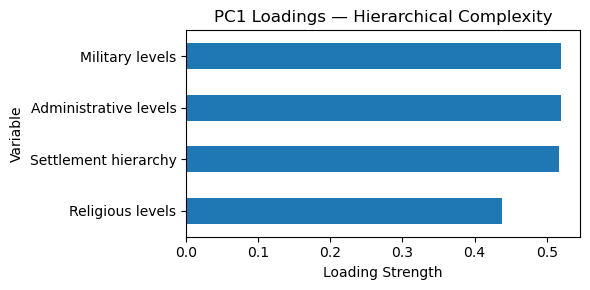

In [23]:
#START of visualization

loadings["PC1"].sort_values().plot(kind="barh", figsize=(6,3))
plt.title("PC1 Loadings — Hierarchical Complexity")
plt.xlabel("Loading Strength")
plt.tight_layout()
plt.show()


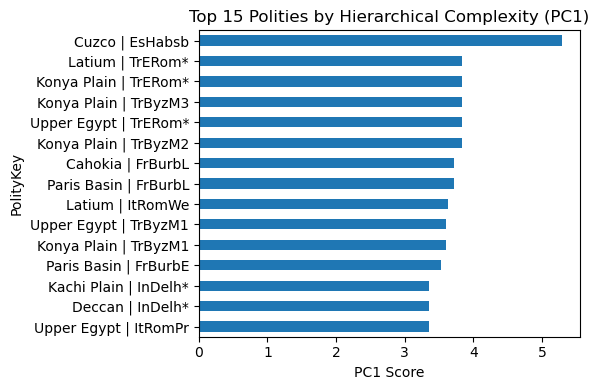

In [24]:
#Visualize via rank
pc1.sort_values(ascending=True).tail(15).plot(kind="barh", figsize=(6,4))
plt.title("Top 15 Polities by Hierarchical Complexity (PC1)")
plt.xlabel("PC1 Score")
plt.tight_layout()
plt.show()

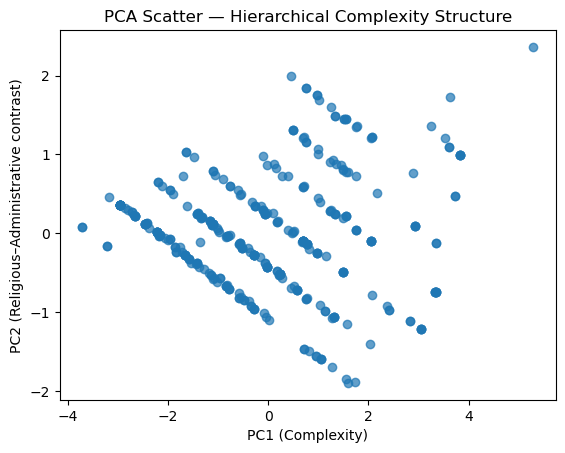

In [25]:
plt.scatter(scores[:,0], scores[:,1], alpha=0.7)
plt.xlabel("PC1 (Complexity)")
plt.ylabel("PC2 (Religious–Administrative contrast)")
plt.title("PCA Scatter — Hierarchical Complexity Structure")
plt.show()

In [26]:
#Diagnostics

#Dataset overview before PCA
print("Number of unique NGAs:", df["NGA"].nunique()) #NGA is Natural Geographic Areas
print("Number of unique Polities:", df["Polity"].nunique())

#After cleaning
print("Polities retained after cleaning:", wide_core.shape[0])
print("Variables retained:", wide_core.shape[1])
print("Missing value ratio (overall):", 1 - np.mean(np.isfinite(wide_core)))

#Summary of PC1 spread
print("PC1 range:", round(pc1.min(), 2), "to", round(pc1.max(), 2))
print("PC1 mean ± std:", round(pc1.mean(), 2), "±", round(pc1.std(), 2))


Number of unique NGAs: 30
Number of unique Polities: 398
Polities retained after cleaning: 378
Variables retained: 4
Missing value ratio (overall): 0.03240740740740744
PC1 range: -3.71 to 5.29
PC1 mean ± std: -0.0 ± 1.74


In [27]:
#NGA count
wide_core.index.str.extract(r"([A-Za-z\s]+)\s\|")[0].value_counts().head(10)

0
Susiana                       40
Upper Egypt                   36
Konya Plain                   33
Middle Yellow River Valley    31
Sogdiana                      26
Kachi Plain                   23
Paris Basin                   21
Latium                        20
Orkhon Valley                 20
Deccan                        16
Name: count, dtype: int64

In [62]:
#Polity longeitivty check

df["PolityKey"] = df["NGA"].astype(str) + " | " + df["Polity"].astype(str)

def to_year(x):
    if pd.api.types.is_number(x): 
        return float(x)
    if isinstance(x, str):
        s = x.lower().strip().replace("–","-").replace("—","-")
        digs = ''.join(ch for ch in s if ch.isdigit() or ch=='-')
        if digs == "": return np.nan
        if "bce" in s:  return -abs(float(digs))
        if "ce"  in s:  return float(digs)
        try: return float(digs)
        except: return np.nan
    return np.nan

df["DateFrom_num"] = df["Date From"].apply(to_year)
df["DateTo_num"]   = df["Date To"].apply(to_year)

timeline_est = (df.groupby("PolityKey", as_index=False)
                  .agg(start_year_est=("DateFrom_num","min"),
                       end_year_est=("DateTo_num","max")))

#keep rows with at least one bound
timeline_est = timeline_est.dropna(subset=["start_year_est", "end_year_est"], how="all")
timeline_est["duration_years_est"] = timeline_est["end_year_est"] - timeline_est["start_year_est"]

print(timeline_est.columns.tolist())

['PolityKey', 'start_year_est', 'end_year_est', 'duration_years_est']


In [63]:
#Sanity print
print("Polities with usable timeline:", len(timeline_est))
print(timeline_est["duration_years_est"].describe().round(1))


Polities with usable timeline: 255
count     119.0
mean      228.0
std       190.3
min        36.0
25%       113.5
50%       162.0
75%       281.5
max      1100.0
Name: duration_years_est, dtype: float64


In [65]:
cols = ["start_year_est", "end_year_est"]
missing_timeline = timeline_est.loc[timeline_est[cols].isna().any(axis=1), ["PolityKey"] + cols]
print("Missing timeline entries:", len(missing_timeline))
missing_timeline.head(20)



Missing timeline entries: 136


,PolityKey,start_year_est,end_year_est
4,Big Island Hawaii | USKameh,1800.0,NaN
20,Cambodian Basin | KhAngkE,800.0,NaN
32,Central Java | IdKedir,1100.0,NaN
39,Cuzco | EsHabsb,1550.0,NaN
40,Cuzco | PeCuzE1,200.0,NaN
52,Deccan | InChaBd,600.0,NaN
53,Deccan | InChaKl,1000.0,NaN
59,Deccan | InKadam,-500.0,NaN
65,Deccan | InRasht,800.0,NaN
68,Deccan | InVakat,300.0,NaN


In [66]:
#Filling in data for known civ bounds
manual_bounds = {
    "Latium | ItRomPr": (-753, -27),        # Roman Kingdom & Republic
    "Latium | ItRomWe": (-27, 476),         # Western Roman Empire
    "Latium | TrERom*": (27, 1453),         # Eastern Roman (Byzantine) continuation
    "Upper Egypt | EgNK": (-3100, -2686),   # Early Dynastic Egypt
    "Upper Egypt | EgOK": (-2686, -2181),   # Old Kingdom
    "Upper Egypt | EgNKRam": (-1292, -1077),
    "Deccan | InMugl*": (1526, 1857),       # Mughal Empire
    "Kachi Plain | InDelh*": (1206, 1526),  # Delhi Sultanate
    "Middle Yellow River Valley | CnHan*": (-206, 220),   # Han China
    "Middle Yellow River Valley | CnMing*": (1368, 1644),
    "Cuzco | EsHabsb": (1438, 1533),        # Inca Empire
    "Valley of Oaxaca | MxAlb3B": (-500, 800),  # Monte Albán IIIb
}


In [77]:
mb_df = (
    pd.DataFrame.from_dict(
        manual_bounds, orient="index",
        columns=["start_year_est","end_year_est"]
    ).reset_index().rename(columns={"index":"PolityKey"})
)

# Drop existing keys then append manual bounds
timeline_est = timeline_est[~timeline_est["PolityKey"].isin(mb_df["PolityKey"])]
timeline_est = pd.concat([timeline_est, mb_df], ignore_index=True)
timeline_est["duration_years_est"] = timeline_est["end_year_est"] - timeline_est["start_year_est"]


In [78]:
# Drop existing keys then append manual bounds
timeline_est = timeline_est[~timeline_est["PolityKey"].isin(mb_df["PolityKey"])]
timeline_est = pd.concat([timeline_est, mb_df], ignore_index=True)
timeline_est["duration_years_est"] = timeline_est["end_year_est"] - timeline_est["start_year_est"]

# Join PC1 safely
if 'pc1' in globals():
    pc1_df = pc1.rename("PC1_hier").reset_index()
    if "PC1_hier" in timeline_est.columns:
        timeline_est = timeline_est.drop(columns=["PC1_hier"])
    timeline_est = timeline_est.merge(pc1_df, on="PolityKey", how="left")


In [84]:
#PLOT HELPERS

def _ensure_figdir():
    os.makedirs("figures", exist_ok=True)

def _clip_norm(series, lo=-2, hi=3):
    s = series.clip(lower=lo, upper=hi)
    return (s - s.min()) / (s.max() - s.min() + 1e-9), s  # return norm in [0,1] and clipped

def _window(df, year_min=None, year_max=None):
    if year_min is not None:
        df = df[df["end_year_est"] >= year_min]
    if year_max is not None:
        df = df[df["start_year_est"] <= year_max]
    return df

def _draw_hlines(ax, s_arr, e_arr, norm_arr=None, linewidth=2.2):
    if norm_arr is None:
        for i, (s,e) in enumerate(zip(s_arr, e_arr)):
            ax.hlines(i, s, e, linewidth=linewidth)
        return None
    cmap = plt.cm.viridis
    for i, (s, e, c) in enumerate(zip(s_arr, e_arr, norm_arr)):
        ax.hlines(i, s, e, colors=cmap(float(c)), linewidth=linewidth)
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array(norm_arr)
    return sm  # for colorbar

In [85]:
#FULL TIMELINE FUNCTION: every polity/phase

def plot_timeline_full(timeline_est, year_min=None, year_max=None, save_as="figures/polity_timeline_full.png"):
    """
    Expects columns: PolityKey, start_year_est, end_year_est, (optional) PC1_hier
    """
    _ensure_figdir()
    df = (timeline_est
          .dropna(subset=["start_year_est","end_year_est"])
          .assign(duration_years_est=lambda d: d["end_year_est"] - d["start_year_est"])
          .query("duration_years_est > 0")
          .copy())
    df = _window(df, year_min, year_max)
    df = df.sort_values(["start_year_est","end_year_est"]).reset_index(drop=True)

    norm = None
    if "PC1_hier" in df.columns and df["PC1_hier"].notna().any():
        norm, _ = _clip_norm(df["PC1_hier"], lo=-2, hi=3)

    h = max(8, 0.28 * len(df))
    fig, ax = plt.subplots(figsize=(12, h))
    sm = _draw_hlines(ax,
                      np.maximum(df["start_year_est"].to_numpy(), year_min if year_min is not None else -1e9),
                      np.minimum(df["end_year_est"].to_numpy(), year_max if year_max is not None else 1e9),
                      norm_arr=norm)

    if sm is not None:
        cbar = fig.colorbar(sm, ax=ax); cbar.set_label("PC1 (Hierarchical Complexity)")

    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df["PolityKey"], fontsize=7)
    if year_min is not None and year_max is not None:
        ax.set_xlim(year_min, year_max)
    ax.set_xlabel("Year (BCE negative → CE positive)")
    ax.set_title("Polity Longevity — full (every polity/phase)")
    plt.tight_layout(); plt.savefig(save_as, dpi=300, bbox_inches="tight"); plt.show()
    return df  # return plotted table for reference


In [86]:
#COLLAPSED FUNCTION: merge phases per polity code
def plot_timeline_collapsed(timeline_est, year_min=None, year_max=None, save_as="figures/polity_timeline_collapsed.png"):
    """
    Collapses phases by PolityCode (text after '|'), averages PC1, shows (n=phases).
    Expects columns: PolityKey, start_year_est, end_year_est, (optional) PC1_hier
    """
    _ensure_figdir()
    df = (timeline_est
          .dropna(subset=["start_year_est","end_year_est"])
          .assign(duration_years_est=lambda d: d["end_year_est"] - d["start_year_est"])
          .query("duration_years_est > 0")
          .copy())
    df["PolityCode"] = df["PolityKey"].str.split("|").str[1].str.strip()

    collapsed = (df
        .groupby("PolityCode", as_index=False)
        .agg(start_year_est=("start_year_est","min"),
             end_year_est=("end_year_est","max"),
             PC1_hier=("PC1_hier","mean"),
             n_phases=("PolityKey","nunique")))

    collapsed = _window(collapsed, year_min, year_max)
    collapsed = collapsed.sort_values("start_year_est").reset_index(drop=True)
    collapsed["label"] = collapsed["PolityCode"] + " (n=" + collapsed["n_phases"].astype(str) + ")"

    norm = None
    if "PC1_hier" in collapsed.columns and collapsed["PC1_hier"].notna().any():
        norm, _ = _clip_norm(collapsed["PC1_hier"], lo=-2, hi=3)

    h = max(8, 0.28 * len(collapsed))
    fig, ax = plt.subplots(figsize=(12, h))
    sm = _draw_hlines(ax,
                      np.maximum(collapsed["start_year_est"].to_numpy(), year_min if year_min is not None else -1e9),
                      np.minimum(collapsed["end_year_est"].to_numpy(), year_max if year_max is not None else 1e9),
                      norm_arr=norm)

    if sm is not None:
        cbar = fig.colorbar(sm, ax=ax); cbar.set_label("PC1 (Hierarchical Complexity)")

    ax.set_yticks(np.arange(len(collapsed)))
    ax.set_yticklabels(collapsed["label"], fontsize=8)
    if year_min is not None and year_max is not None:
        ax.set_xlim(year_min, year_max)
    ax.set_xlabel("Year (BCE negative → CE positive)")
    ax.set_title("Polity Longevity — collapsed by polity (label includes phase count)")
    plt.tight_layout(); plt.savefig(save_as, dpi=300, bbox_inches="tight"); plt.show()
    return collapsed

In [87]:
#HYBRID FUNCTION
def plot_timeline_hybrid(timeline_est, year_min=None, year_max=None,
                         save_as="figures/polity_timeline_hybrid.png"):
    """
    Hybrid: collapse by 'root' (NGA|token) but label with polity code (right of '|') + (n=phases).
    Expects columns: PolityKey, start_year_est, end_year_est, (optional) PC1_hier
    """
    _ensure_figdir()

    df = (timeline_est
          .dropna(subset=["start_year_est","end_year_est"])
          .assign(duration_years_est=lambda d: d["end_year_est"] - d["start_year_est"])
          .query("duration_years_est > 0")
          .copy())

    # Build root (left side + first token after '|') and polity code (right-of-pipe)
    df["root"] = df["PolityKey"].str.replace(r"(\| \w+?).*", r"\1", regex=True)
    df["PolityCode"] = df["PolityKey"].str.split("|").str[1].str.strip()

    # Collapse by root; choose a representative polity label and count phases
    collapsed = (df.groupby("root", as_index=False)
                   .agg(start_year_est=("start_year_est","min"),
                        end_year_est=("end_year_est","max"),
                        PC1_hier=("PC1_hier","mean"),
                        n_phases=("PolityKey","nunique"),
                        label=("PolityCode", lambda x: x.mode().iat[0] if not x.mode().empty else x.iloc[0])))

    # Time window
    collapsed = _window(collapsed, year_min, year_max)
    collapsed = collapsed.sort_values("start_year_est").reset_index(drop=True)

    # Final label with phase count
    collapsed["label"] = collapsed["label"] + " (n=" + collapsed["n_phases"].astype(str) + ")"

    # Color normalization (clip for perceptual spread)
    norm = None
    if "PC1_hier" in collapsed.columns and collapsed["PC1_hier"].notna().any():
        norm, _ = _clip_norm(collapsed["PC1_hier"], lo=-2, hi=3)

    # Plot
    import numpy as np, matplotlib.pyplot as plt
    h = max(8, 0.28 * len(collapsed))
    fig, ax = plt.subplots(figsize=(12, h))

    s_arr = np.maximum(collapsed["start_year_est"].to_numpy(),
                       year_min if year_min is not None else -1e9)
    e_arr = np.minimum(collapsed["end_year_est"].to_numpy(),
                       year_max if year_max is not None else 1e9)

    sm = _draw_hlines(ax, s_arr, e_arr, norm_arr=norm, linewidth=2.2)
    if sm is not None:
        cbar = fig.colorbar(sm, ax=ax); cbar.set_label("PC1 (Hierarchical Complexity)")

    ax.set_yticks(np.arange(len(collapsed)))
    ax.set_yticklabels(collapsed["label"], fontsize=8)
    if year_min is not None and year_max is not None:
        ax.set_xlim(year_min, year_max)

    ax.set_xlabel("Year (BCE negative → CE positive)")
    ax.set_title("Polity Longevity (root-collapsed; color=complexity; label=polity, n=phases)")
    plt.tight_layout(); plt.savefig(save_as, dpi=300, bbox_inches="tight"); plt.show()
    return collapsed

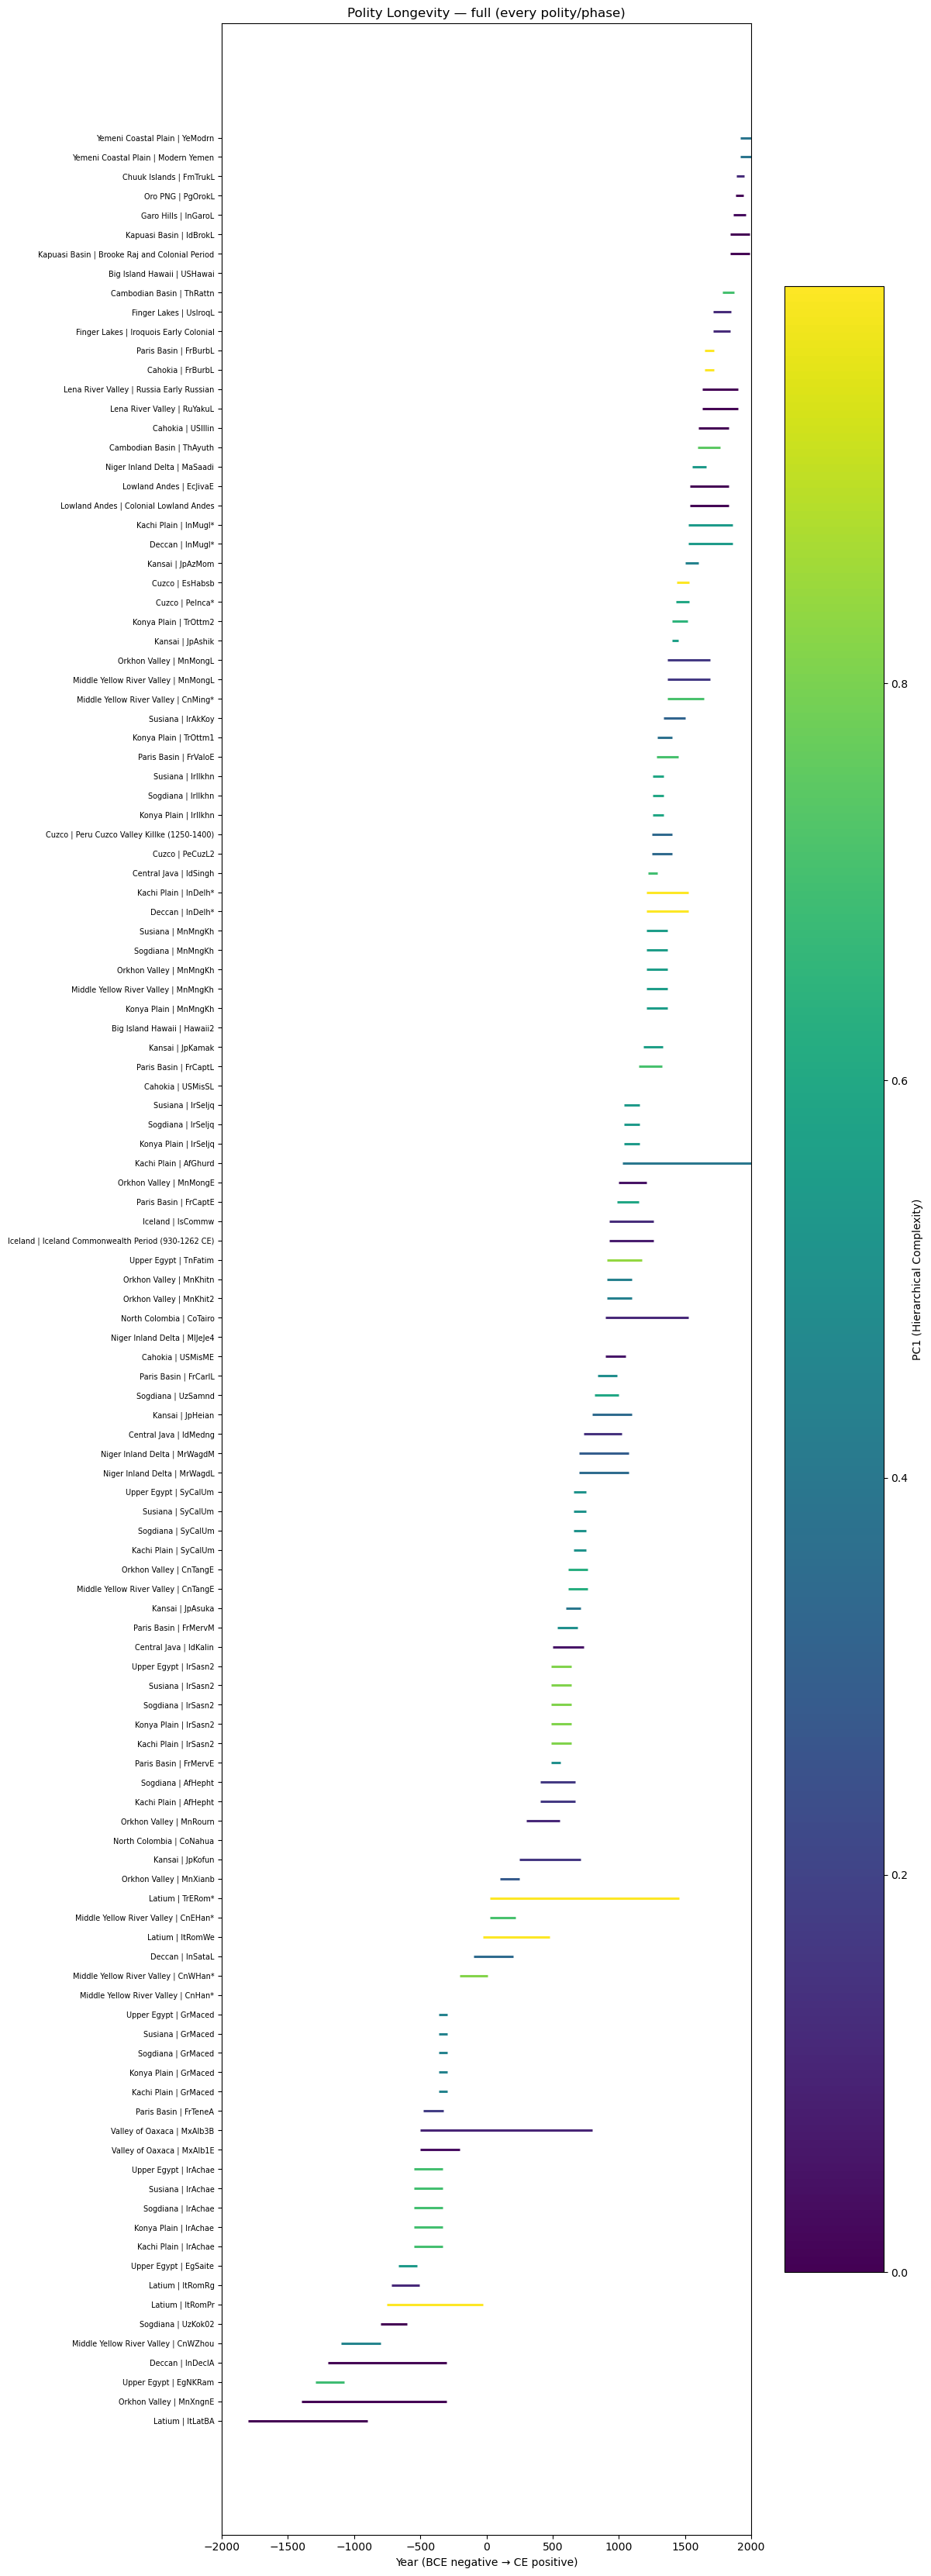

In [89]:
full_tbl      = plot_timeline_full(timeline_est, year_min=-2000, year_max=2000)

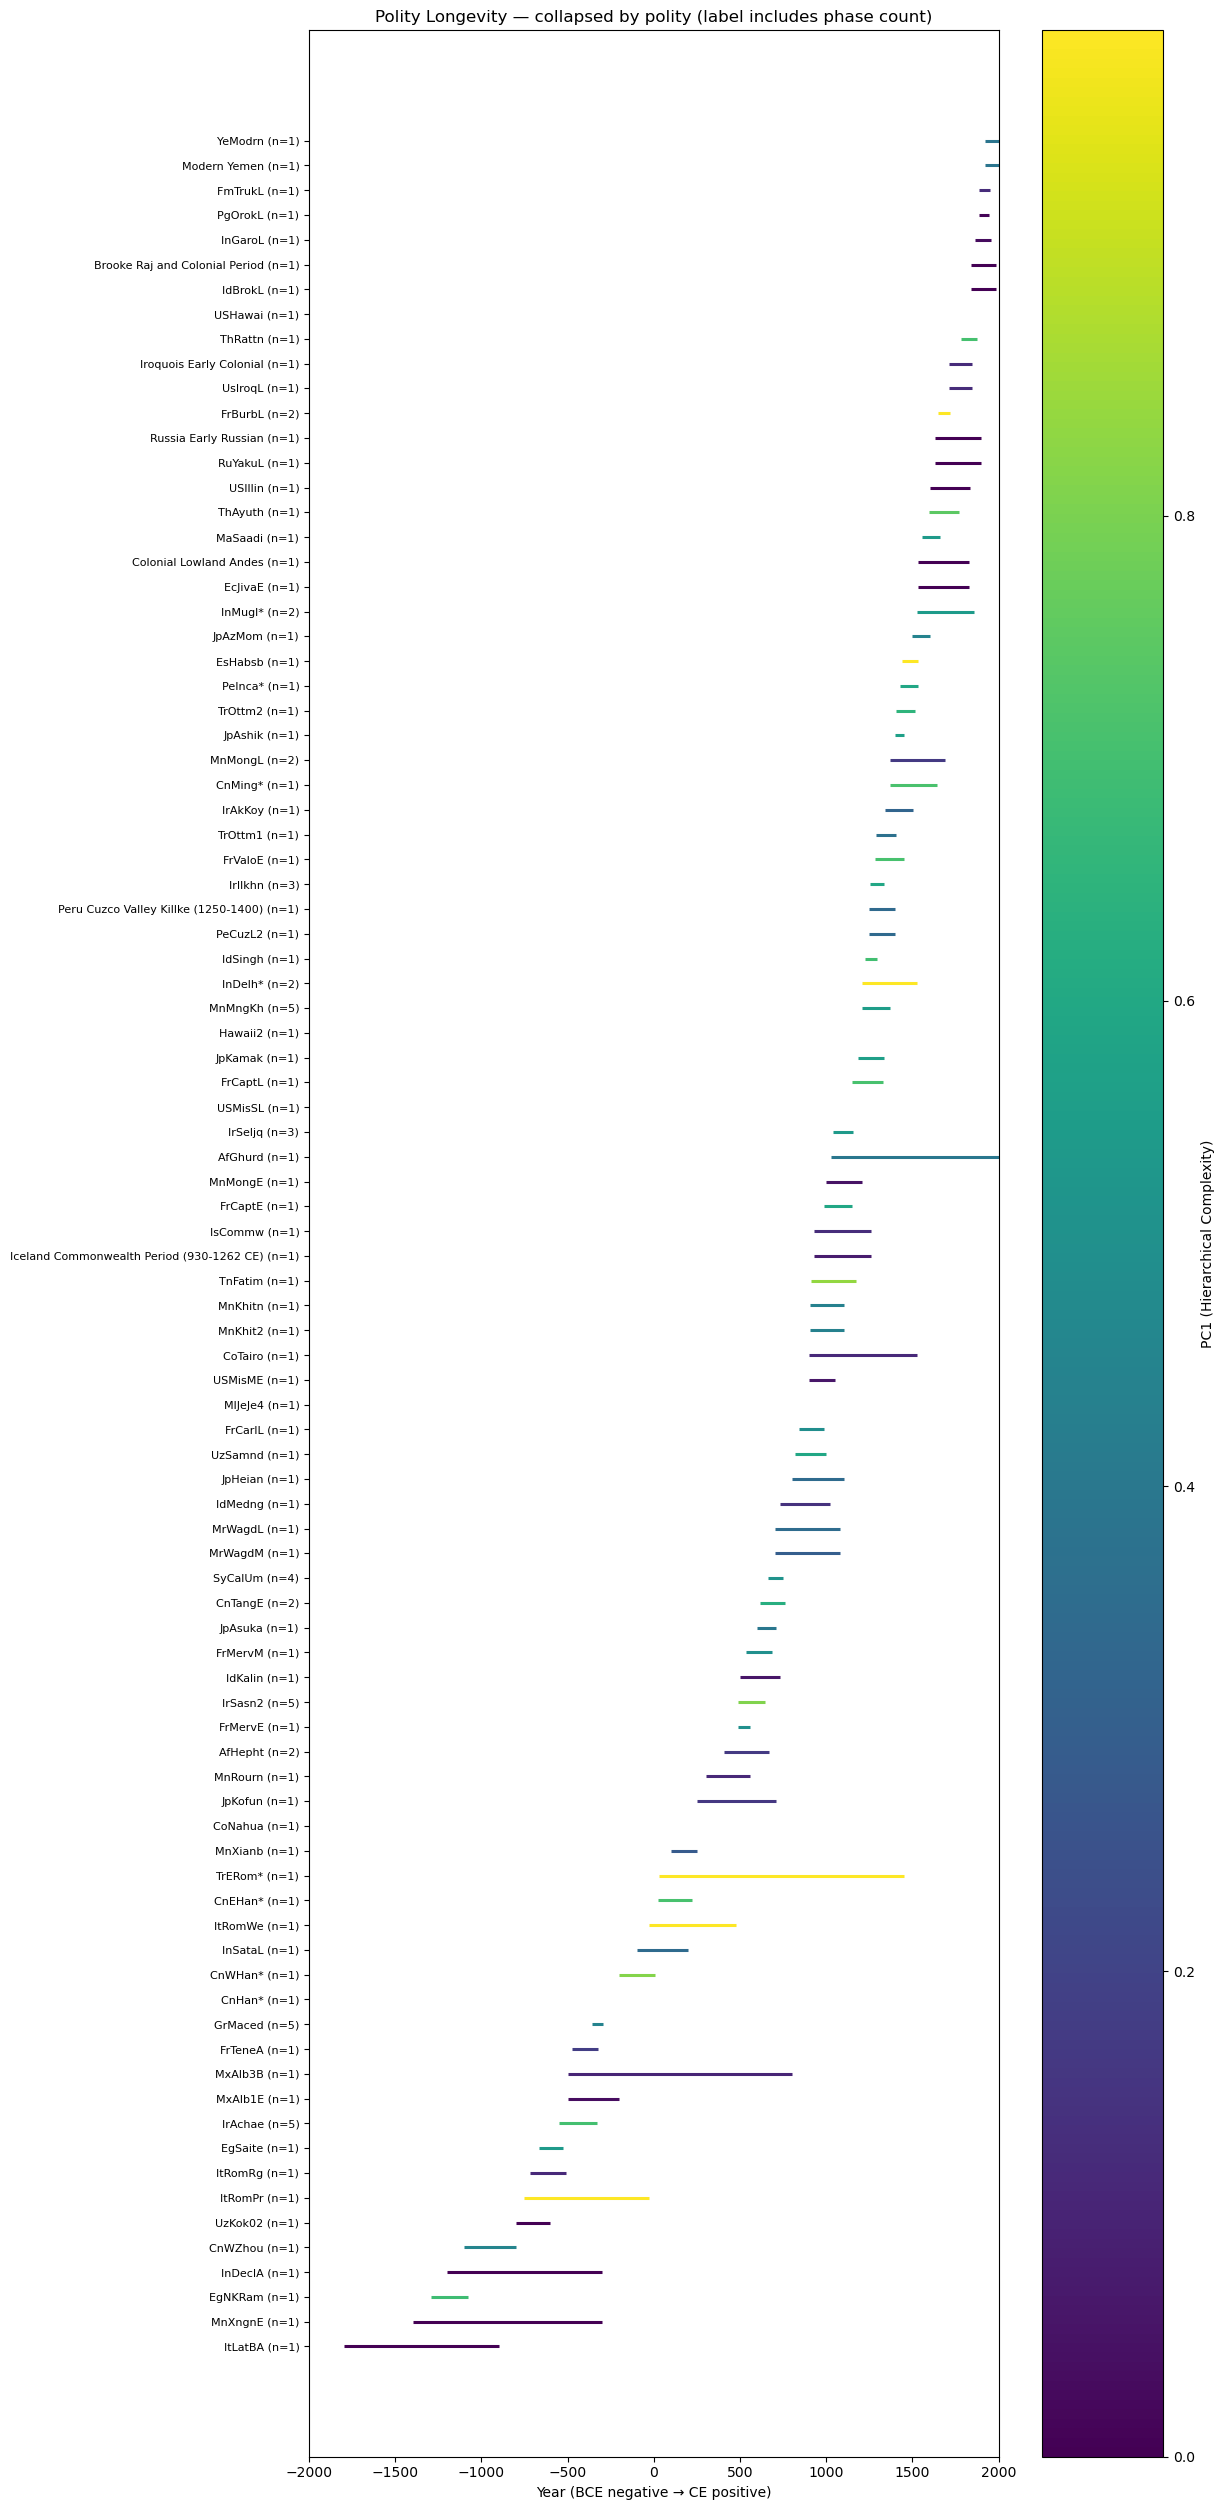

In [90]:
collapsed_tbl = plot_timeline_collapsed(timeline_est, year_min=-2000, year_max=2000)

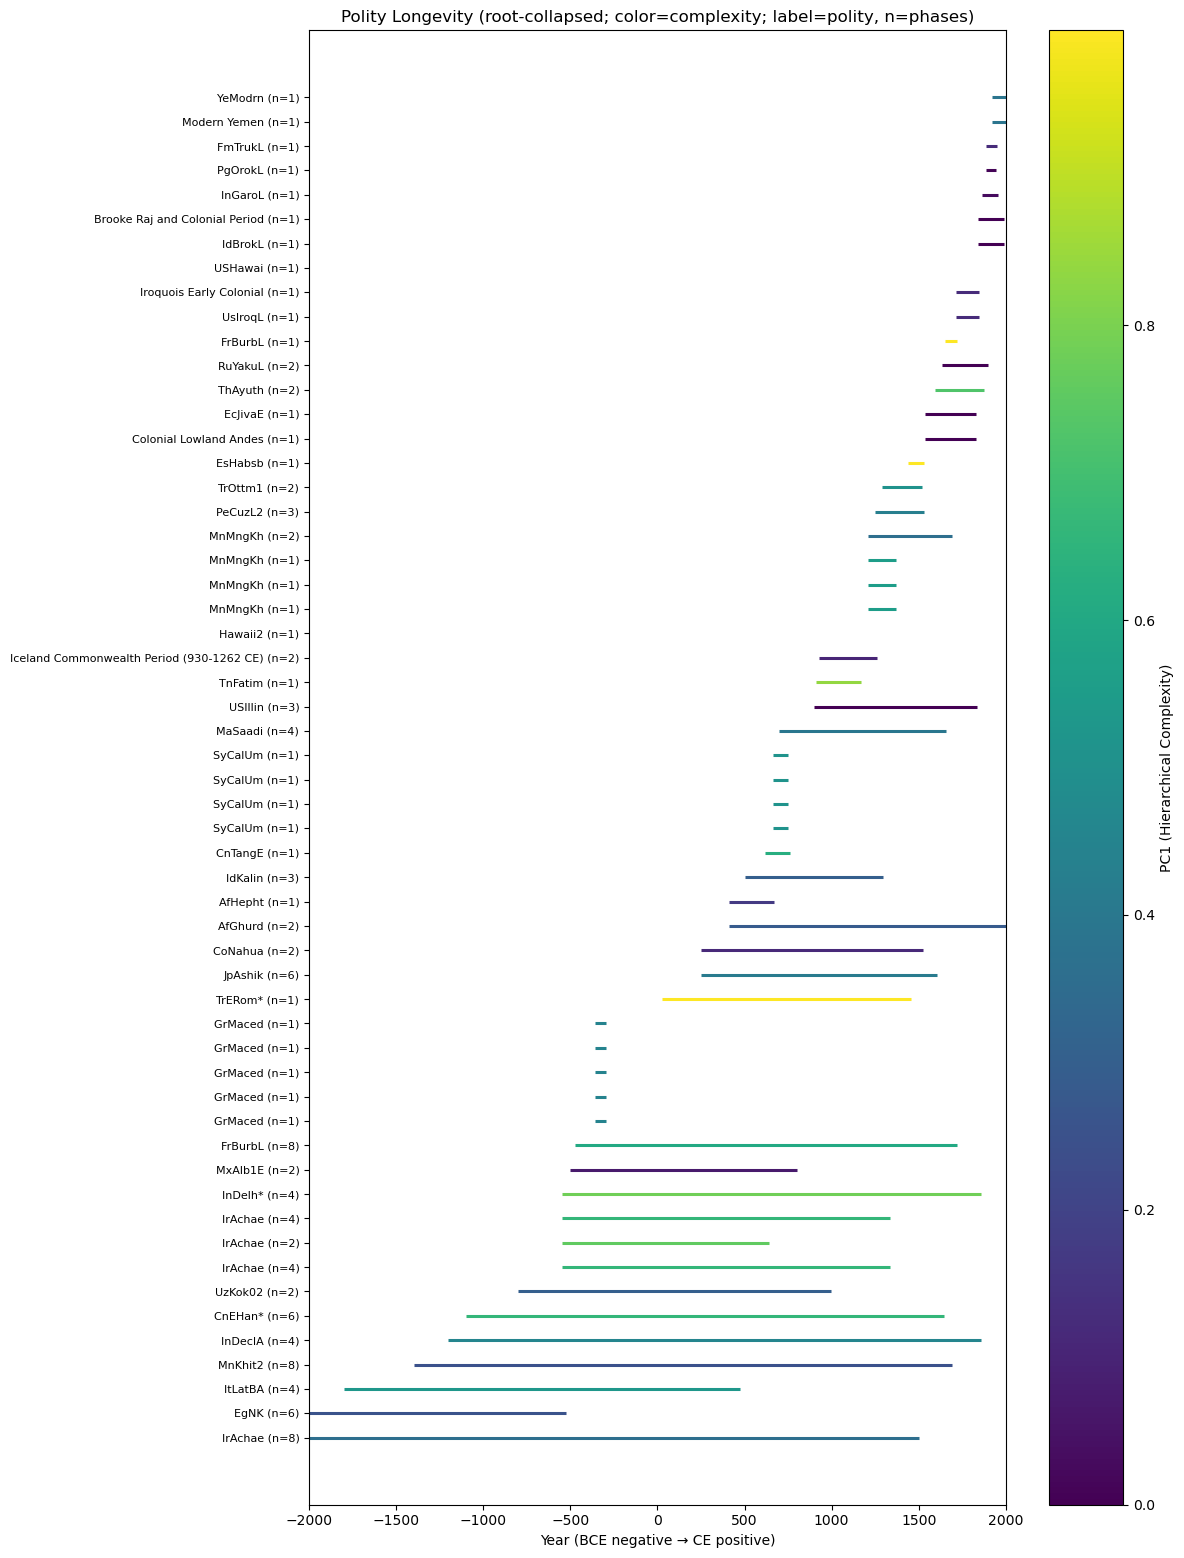

In [91]:
hybrid_tbl    = plot_timeline_hybrid(timeline_est, year_min=-2000, year_max=2000)